# 0.0 IMPORTS

In [1]:
import math
import pickle
import random
import datetime
import warnings
import pandas              as pd
import numpy               as np
import xgboost             as xgb
import seaborn             as sns
import plotly.express      as px

from boruta                import BorutaPy
from scipy                 import stats  as ss
from matplotlib            import gridspec
from IPython.display       import Image
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML


from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

In [2]:
warnings.filterwarnings('ignore')

## 0.1 Helper functions

In [56]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n) / ( min( kcorr-1, rcorr-1 )))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def mean_percentage_error( y, yhat ):
    return np.mean((y - yhat ) / y)

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # start and end date for validation
        validation_start_date = x_training['Date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['Date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['Date'] < validation_start_date]
        validation = x_training[(x_training['Date'] >= validation_start_date) & (x_training['Date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['Date', 'Sales'], axis=1 )
        ytraining = training['Sales']

        # validation
        xvalidation = validation.drop( ['Date', 'Sales'], axis=1 )
        yvalidation = validation['Sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    return pd.DataFrame({'Model Name': model_name, 'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                             'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                             'RMSE CV': np.round( np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [99]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1.0 Data Description

## 1.1 Loading data

In [4]:
df_sales_raw = pd.read_csv('C:/Users/PICHAU/repos/rossman/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:/Users/PICHAU/repos/rossman/data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df1 = df_raw.copy()

## 1.2 Data dimensions 

In [6]:
print("Columns number: {}".format(df1.shape[1]))
print("Raws number: {}".format(df1.shape[0]))

Columns number: 18
Raws number: 1017209


## 1.3 Data types

In [7]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [8]:
df1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## 1.4 Check and Fillout NA's

In [9]:
df1.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [10]:
df1['CompetitionDistance'].max()

75860.0

In [11]:
df1['CompetitionOpenSinceMonth'].max()

12.0

In [12]:
df1['CompetitionOpenSinceYear'].min()

1900.0

In [15]:
# CompetitionDistance
df1['CompetitionDistance'] = df1['CompetitionDistance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# CompetitionOpenSinceMonth 
df1['CompetitionOpenSinceMonth'] = df1.apply(lambda x: x['Date'].month if math.isnan(x['CompetitionOpenSinceMonth']) else x['CompetitionOpenSinceMonth'], axis=1)

# CompetitionOpenSinceYear
df1['CompetitionOpenSinceYear'] = df1.apply(lambda x: x['Date'].year if math.isnan(x['CompetitionOpenSinceYear']) else x['CompetitionOpenSinceYear'], axis=1)

# Promo2SinceWeek
df1['Promo2SinceWeek'] = df1.apply(lambda x: x['Date'].week if math.isnan(x['Promo2SinceWeek']) else x['Promo2SinceWeek'], axis=1)

# Promo2SinceYear
df1['Promo2SinceYear'] = df1.apply(lambda x: x['Date'].year if math.isnan(x['Promo2SinceYear']) else x['Promo2SinceYear'], axis=1)

# PromoInterval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['PromoInterval'].fillna(0, inplace=True )
df1['month_map'] = df1['Date'].dt.month.map( month_map )
df1['IsPromo'] = df1[['PromoInterval', 'month_map']].apply( lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['month_map'] in x['PromoInterval'].split(',') else 0, axis=1)

## 1.5 Change types

In [16]:
df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype('int64')
df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype('int64')
df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype('int64')
df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype('int64')

In [17]:
df1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int64
CompetitionOpenSinceYear              int64
Promo2                                int64
Promo2SinceWeek                       int64
Promo2SinceYear                       int64
PromoInterval                        object
month_map                            object
IsPromo                               int64
dtype: object

## 1.4 Descriptive statistic

### 1.4.1 Numerical attributes

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [19]:
#Central Tendency - mean, meadina
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [20]:
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,DayOfWeek,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,Sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,Customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,Open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,Promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,SchoolHoliday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,CompetitionDistance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,CompetitionOpenSinceMonth,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,CompetitionOpenSinceYear,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.4.2 Categorical attributes

In [21]:
 cat_attributes.apply(lambda x: x.unique().shape[0])

StateHoliday      4
StoreType         4
Assortment        3
PromoInterval     4
month_map        12
dtype: int64

In [ ]:
aux = df1[(df1['StateHoliday'] != '0') & (df1['Sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='StateHoliday', y='Sales', data=aux)
plt.subplot(1,3,2)
sns.boxplot(x='StateHoliday', y='Sales', data=aux)
plt.subplot(1,3,3)
sns.boxplot(x='Assortment', y='Sales', data=aux)

# 2.0 Feature Engineering

In [22]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

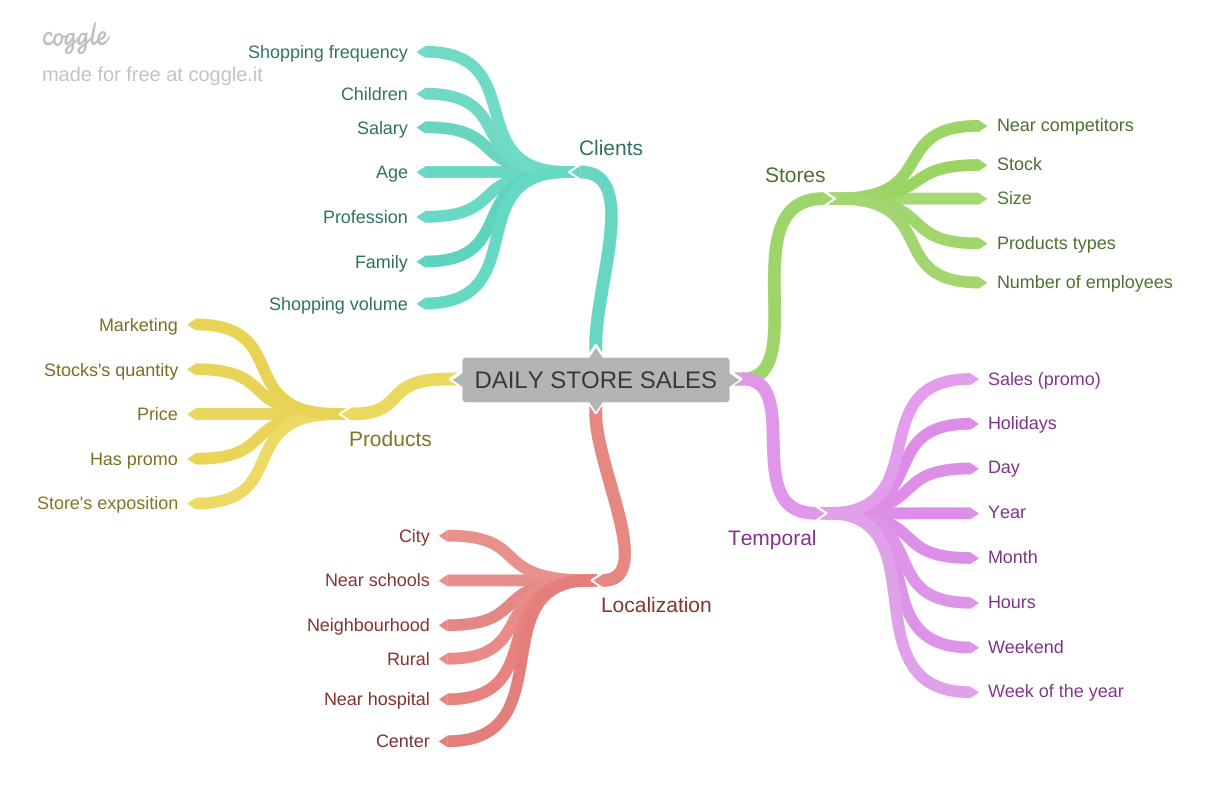

In [22]:
Image('C:/Users/PICHAU/repos/rossman/img/DAILY_STORE_SALES.png')

## 2.2 Hypothesis

All selectioned hypothesis will be discussed in "4.2.1 - Bivariate analyse".

## 2.3 Feature engineering

In [23]:
# year
df2['year'] = df2['Date'].dt.year

# month
df2['month'] = df2['Date'].dt.month

# day
df2['day'] = df2['Date'].dt.day

# week of year
df2['week_of_year'] = df2['Date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['Date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['CompetitionOpenSinceYear'], month=x['CompetitionOpenSinceMonth'],day=1), axis=1)
df2['competition_time_month'] = ((df2['Date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['Promo2SinceYear'].astype(str) + '-' + df2['Promo2SinceWeek'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ((df2['Date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['Assortment'] = df2['Assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['StateHoliday'] = df2['StateHoliday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [24]:
df2.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,IsPromo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226


# 3.0 Data Filtration

In [25]:
df3 = df2.copy()

## 3.1 Rows filtration

In [26]:
df3 = df3[(df3['Open'] != 0) & (df3['Sales'] > 0)]

## 3.2 Columns filtration

In [27]:
cols_drop = ['Customers', 'Open', 'PromoInterval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Exploratory Data Analysis

In [28]:
df4 = df3.copy()

## 4.1 Univariate analyse

### 4.1.1 Response variable

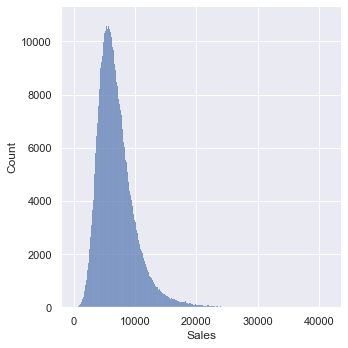

In [101]:
 sns.displot(df4['Sales'], kde=False)

### 4.1.2 Numerical variable

In [30]:
df4.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int64
CompetitionOpenSinceYear              int64
Promo2                                int64
Promo2SinceWeek                       int64
Promo2SinceYear                       int64
IsPromo                               int64
year                                  int64
month                                 int64
day                                   int64
week_of_year                         UInt32
year_week                            object
competition_since            datetime64[ns]
competition_time_month          

In [29]:
df4['competition_time_month'] = df4['competition_time_month'].astype('int64')
df4['promo_time_week'] = df4['promo_time_week'].astype('int64')

In [30]:
num_attributes_eda = df4.select_dtypes(exclude=['object','datetime64[ns]'])

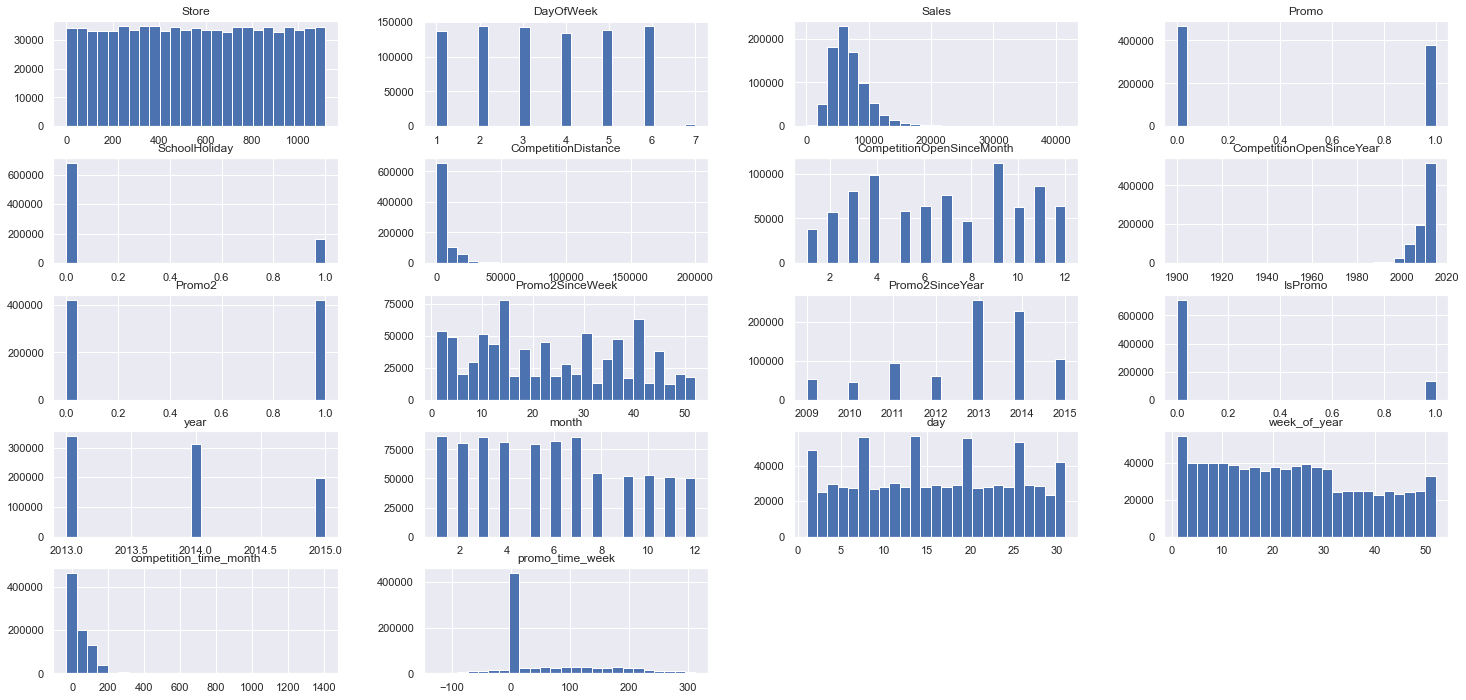

In [102]:
num_attributes_eda.hist(bins=25);

### 4.1.3 Categorical variable

<AxesSubplot:xlabel='Sales', ylabel='Density'>

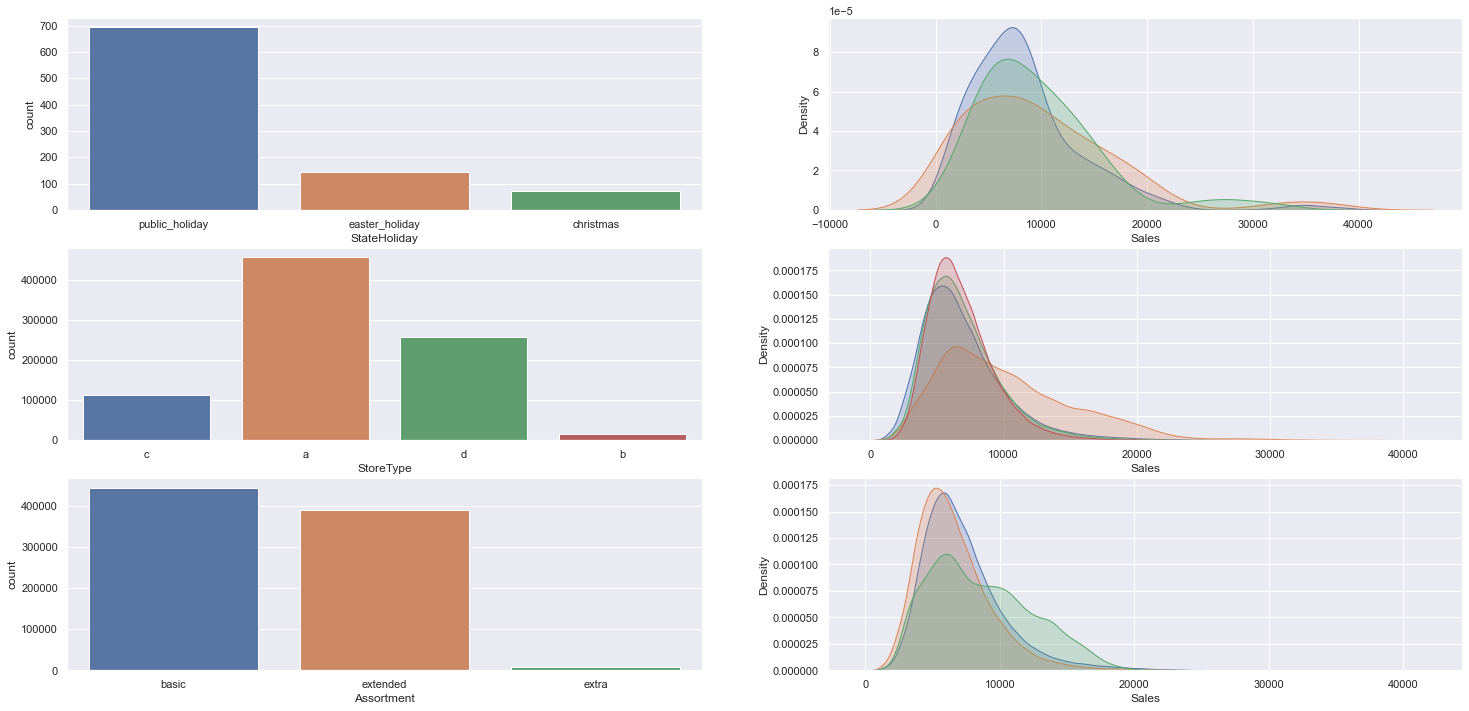

In [103]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['StateHoliday'] != 'regular_day']
sns.countplot(a['StateHoliday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['StateHoliday'] == 'public_holiday']['Sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['StateHoliday'] == 'easter_holiday']['Sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['StateHoliday'] == 'christmas']['Sales'], label='christmas', shade=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['StoreType'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['StoreType'] == 'a']['Sales'], label='a', shade=True)
sns.kdeplot(df4[df4['StoreType'] == 'b']['Sales'], label='b', shade=True)
sns.kdeplot(df4[df4['StoreType'] == 'c']['Sales'], label='c', shade=True)
sns.kdeplot(df4[df4['StoreType'] == 'd']['Sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['Assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['Assortment'] == 'extended']['Sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['Assortment'] == 'basic']['Sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['Assortment'] == 'extra']['Sales'], label='extra', shade=True)

## 4.2 Bivariate analyse

### 4.2.1 Hypothesis

### 1 - More nearest competition, less sales.

FALSE: More nearest competition, more sales.

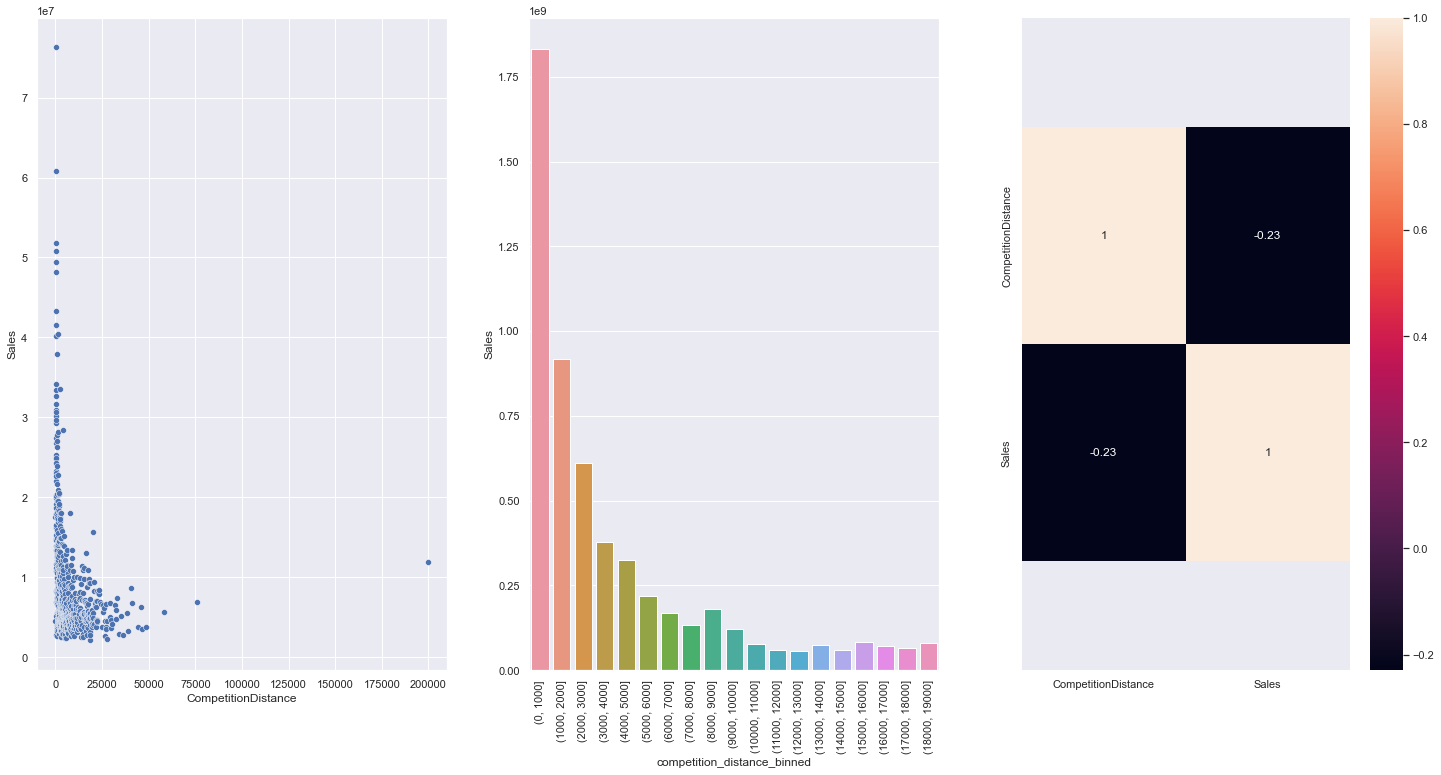

In [104]:
aux1 = df4[['CompetitionDistance', 'Sales']].groupby( 'CompetitionDistance' ).sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x ='CompetitionDistance', y='Sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['CompetitionDistance'],bins=bins)
aux2 = aux1[['competition_distance_binned', 'Sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='Sales', data=aux2 );
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### 2 - More assortment, less sales.

FALSE: Stores with an "extra" assortment level, has more sales on average.  

<AxesSubplot:xlabel='year_week'>

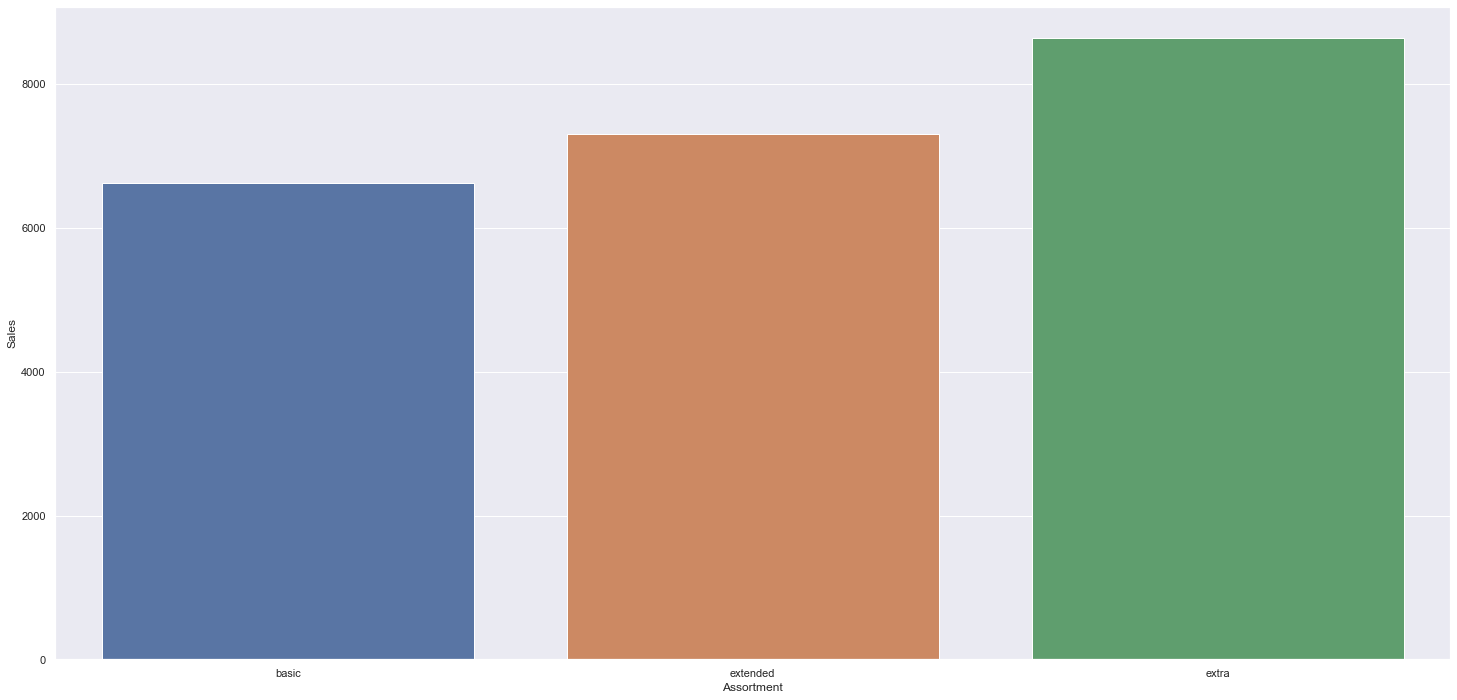

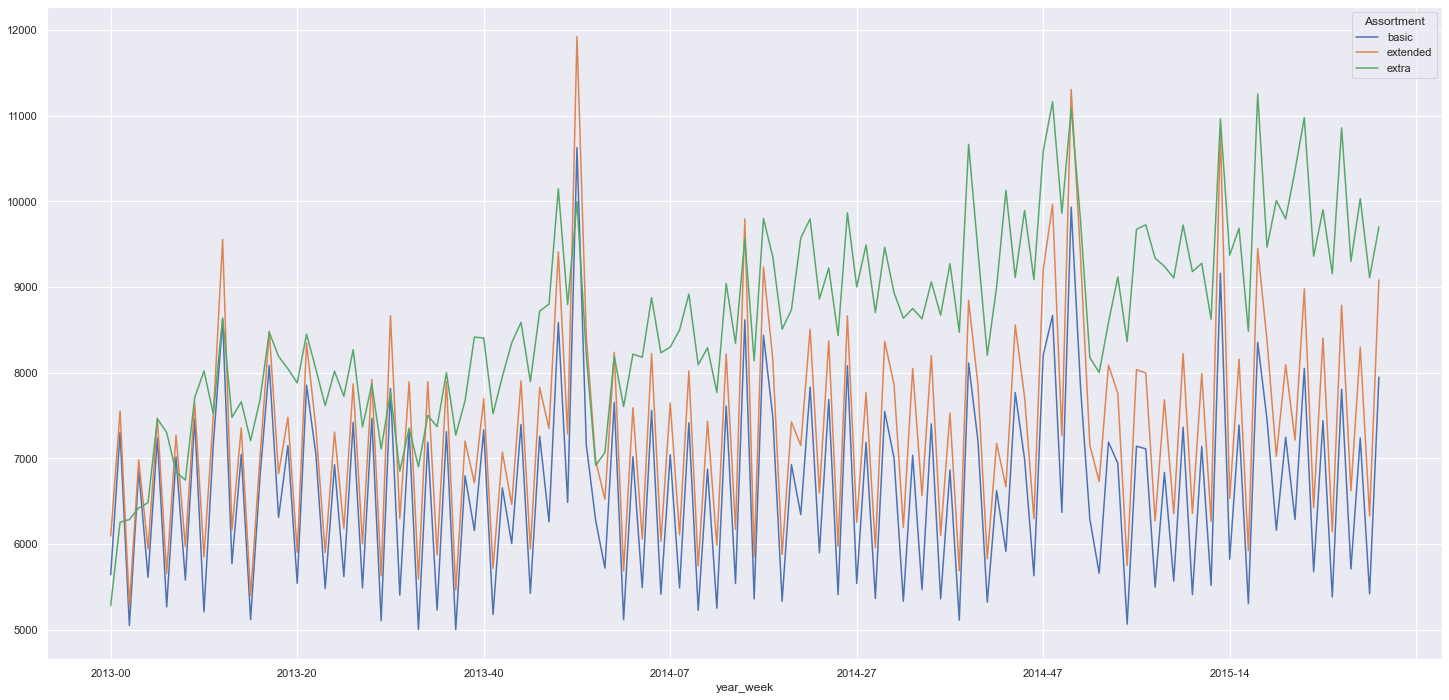

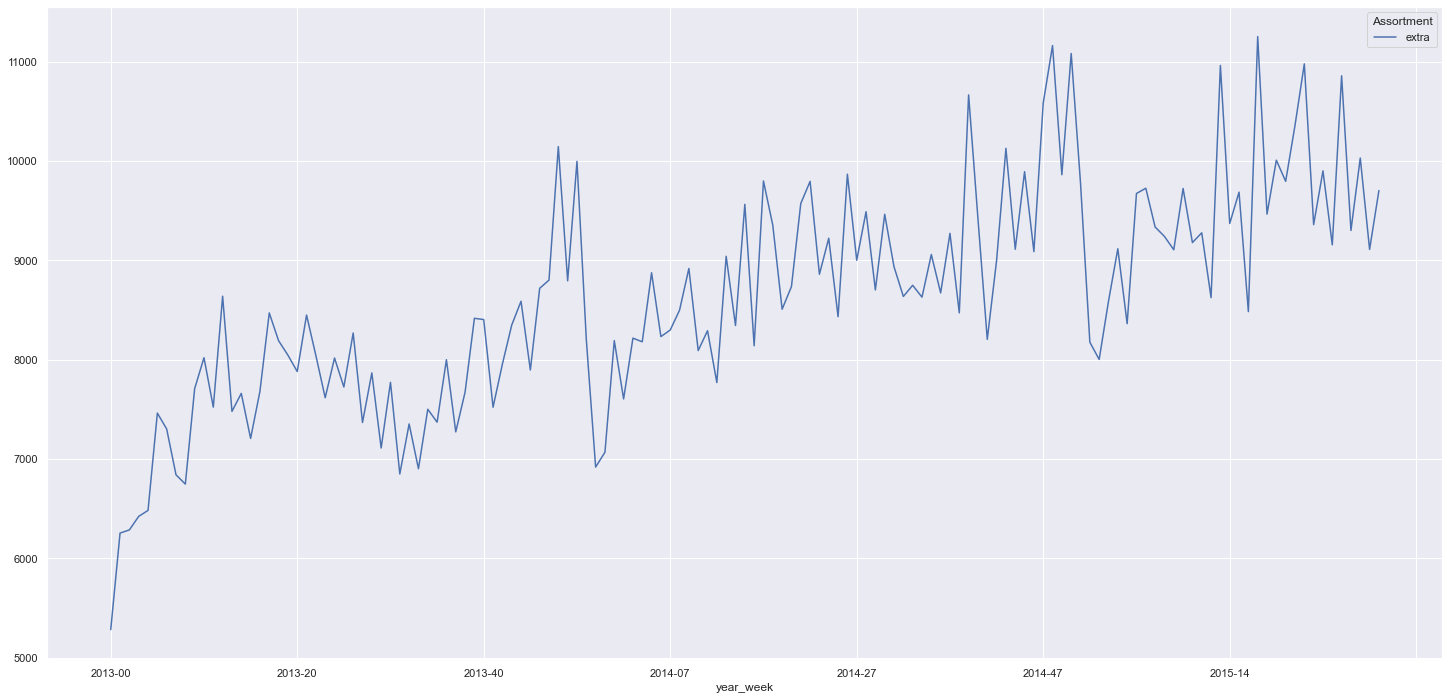

In [105]:
aux1 = df4[['Assortment', 'Sales']].groupby('Assortment').mean().reset_index()
sns.barplot( x='Assortment', y='Sales', data=aux1);

aux2 = df4[['year_week', 'Assortment', 'Sales']].groupby(['year_week','Assortment']).mean().reset_index()
aux2.pivot( index='year_week', columns='Assortment', values='Sales').plot()

aux3 = aux2[aux2['Assortment'] == 'extra']
aux3.pivot( index='year_week', columns='Assortment', values='Sales').plot()

### 3 - More activated promo time, more sales.

FALSE: More activated promo time, less sales.

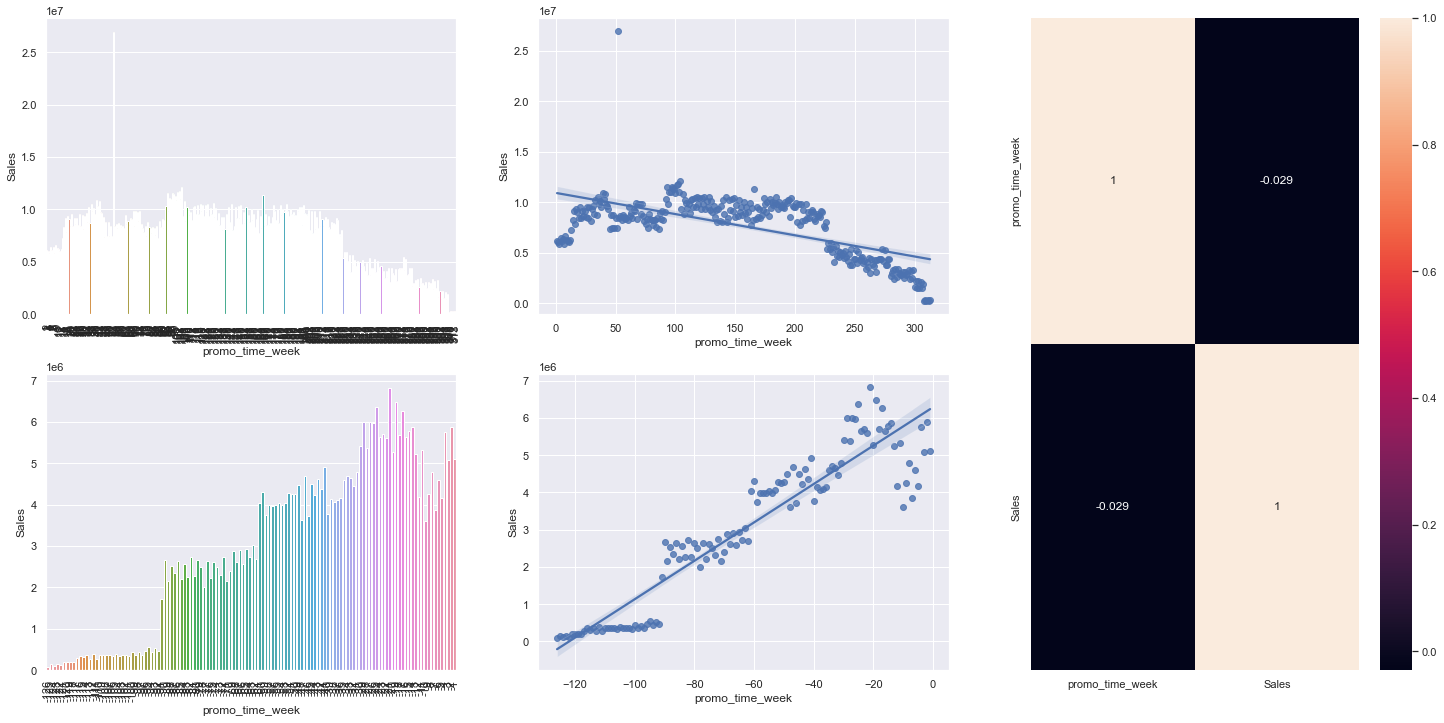

In [106]:
aux1 = df4[['promo_time_week', 'Sales']].groupby('promo_time_week').sum().reset_index()
grid = gridspec.GridSpec(2, 3)
plt.subplot(grid[0,0])

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x='promo_time_week', y='Sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='Sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='Sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='Sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4 - More consecutive promos, more sales.

FALSE: Stores that used only the first promotion, had more sales.  

In [38]:
 df4[['Promo', 'Promo2', 'Sales']].groupby(['Promo', 'Promo2']).sum().reset_index()

,Promo,Promo2,Sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


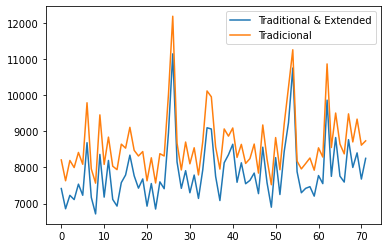

In [39]:
aux1 = df4[(df4['Promo'] == 1) & (df4['Promo2'] == 1)][['year_week','Sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['Promo'] == 1) & (df4['Promo2'] == 0)][['year_week','Sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['Traditional & Extended', 'Tradicional']);

### 5 - More store sales over the years.

FALSE: The stores sales are decreasing over the years.

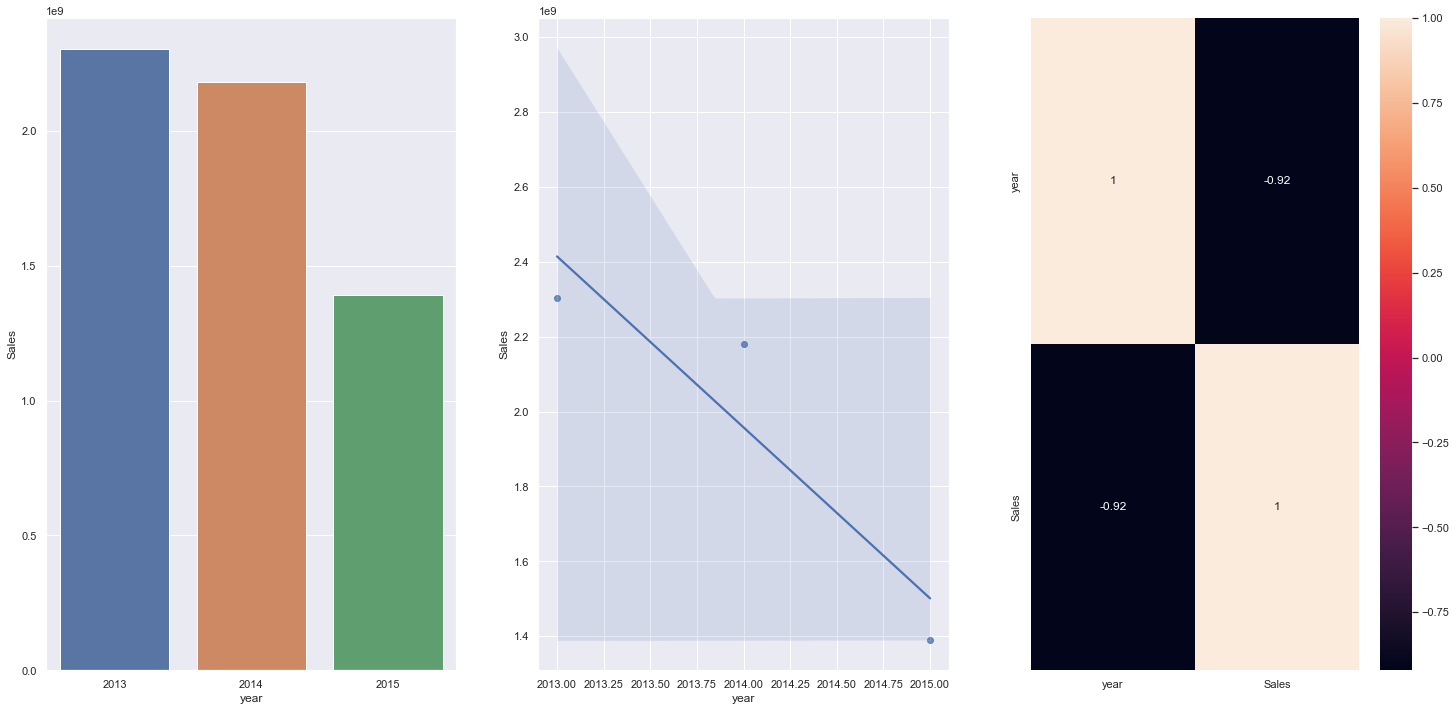

In [107]:
aux1 = df4[['year', 'Sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='Sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='Sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 6 - Stores should have more sales in the second semester of the year.

FALSE: Stores has less sales in the second semester of the year.

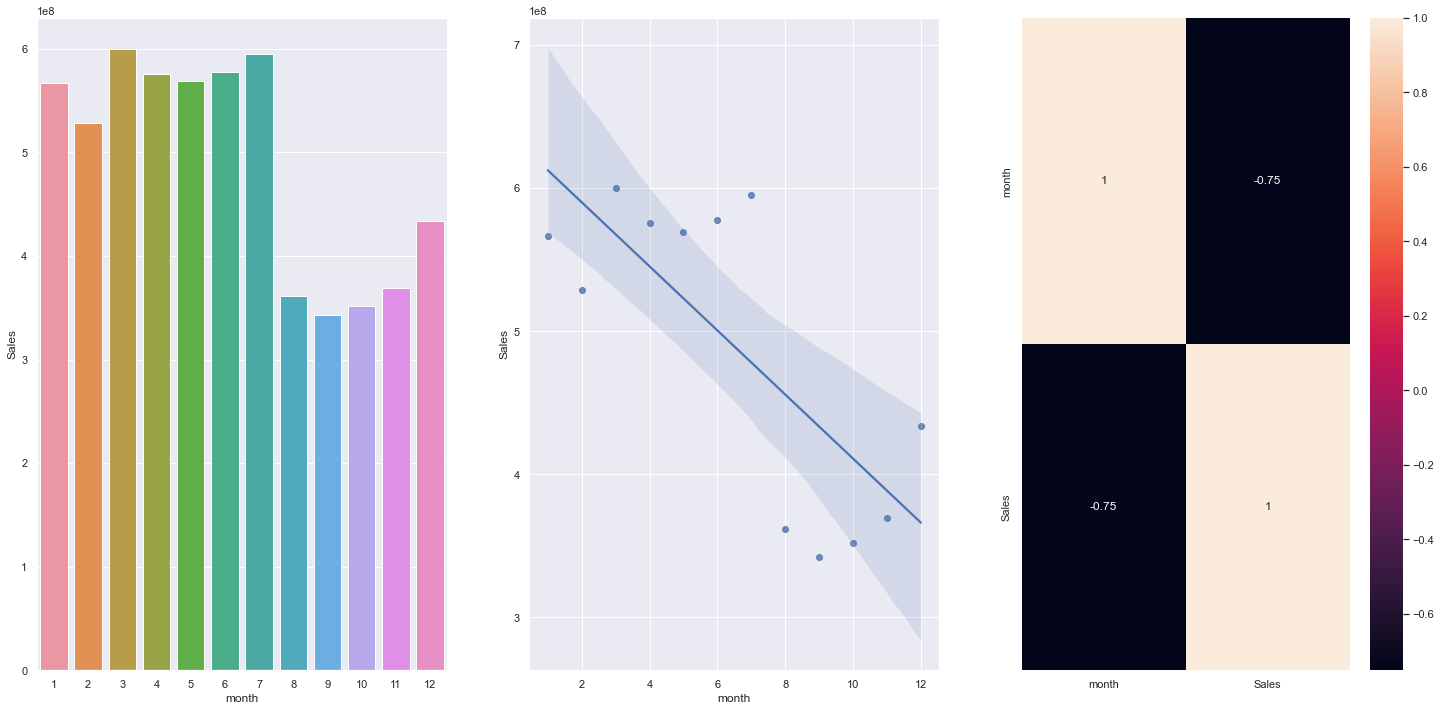

In [108]:
aux1 = df4[['month', 'Sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='Sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot( x='month', y='Sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 7 - Stores should have more sales after the 10th of each month.

TRUE: Stores has more sales after the 10th of each month.

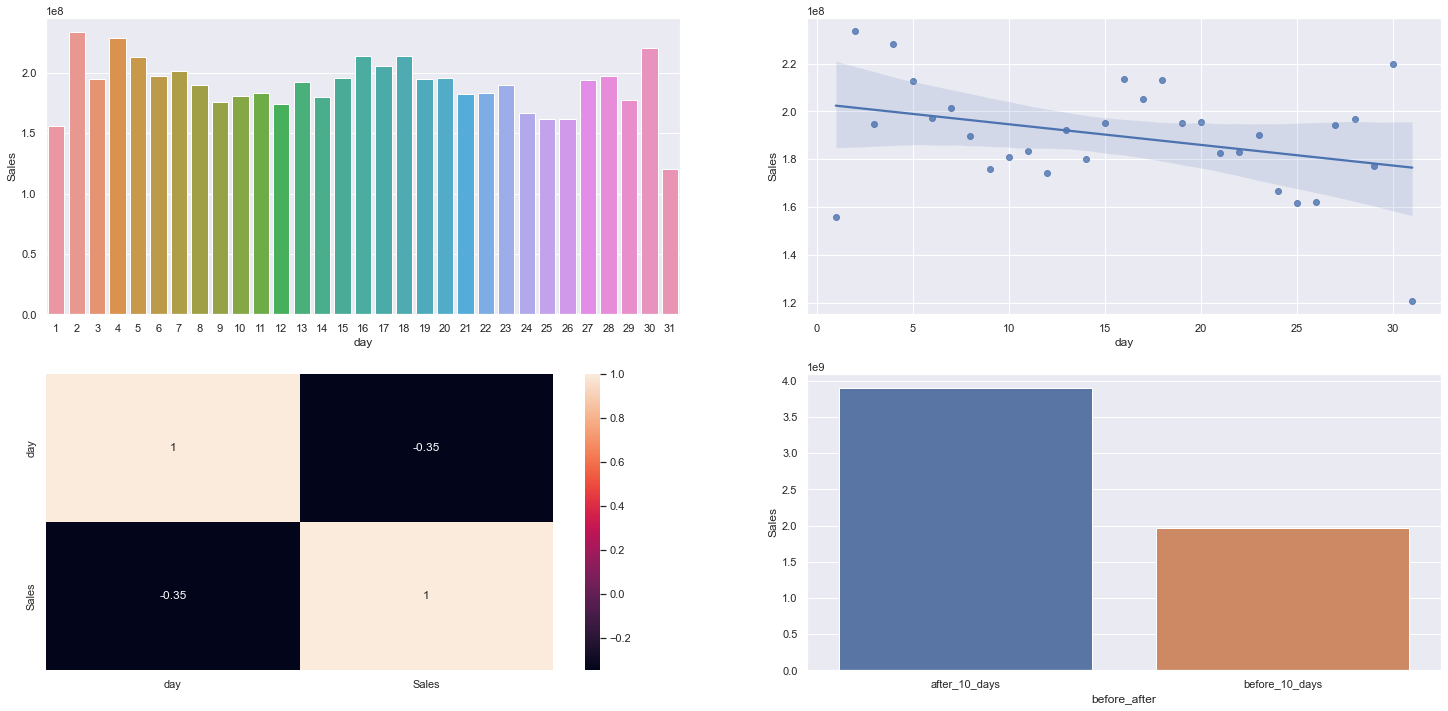

In [109]:
aux1 = df4[['day', 'Sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='Sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='Sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'Sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='Sales', data=aux2);

### 8 - Stores should have less sales on weekends.

TRUE: Stores has less sales on weekends.

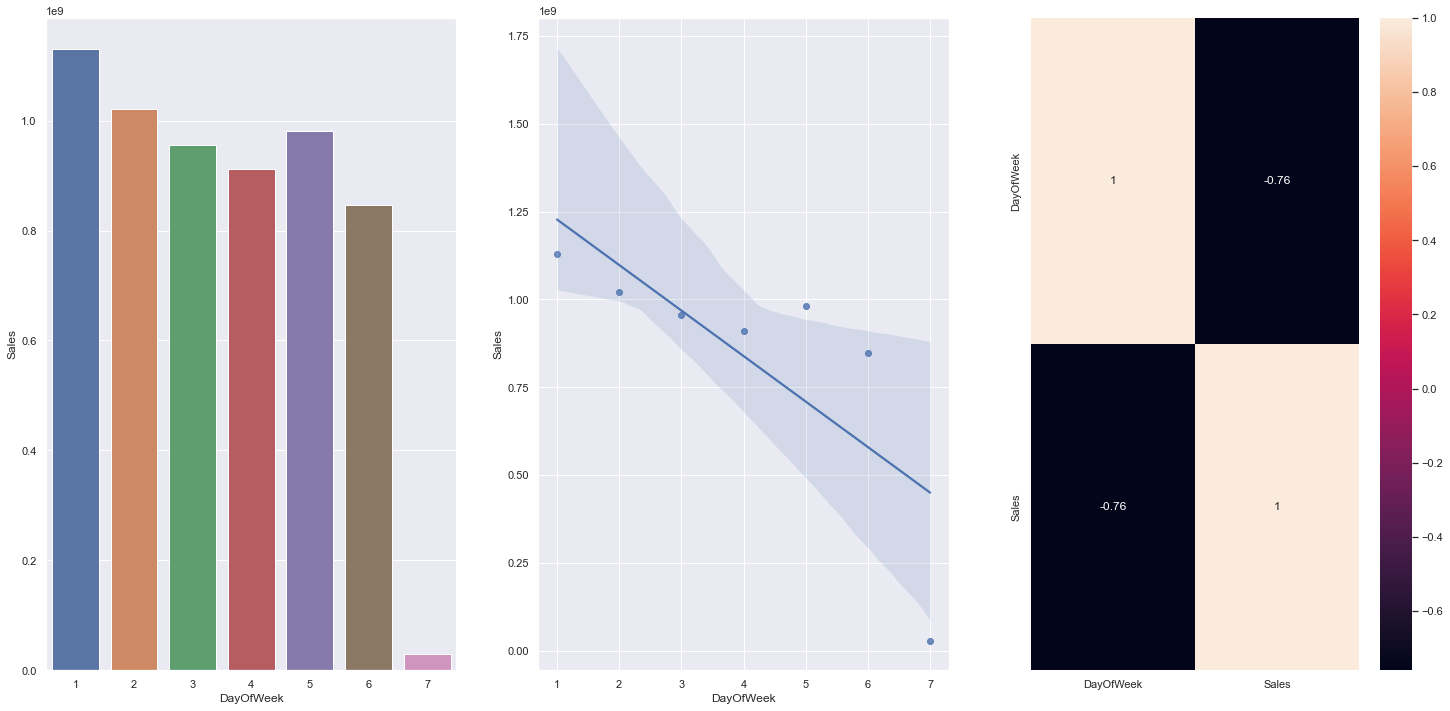

In [110]:
aux1 = df4[['DayOfWeek', 'Sales']].groupby('DayOfWeek').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='DayOfWeek', y='Sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='DayOfWeek', y='Sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.2.2 Check hypothesis

In [44]:
from tabulate import tabulate

In [45]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
         ['1',           'False',      'Low'],
         ['2',           'False',      'Low'],
         ['3',           'False',      'Low'],
         ['4',           'False',      'Low'],
         ['5',           'False',      'High'],
         ['6',           'False',      'High'],
         ['7',           'True',       'Medium'],
         ['8',           'True',       'High'],]

print(tabulate(tab, headers='firstrow'))

  Hypothesis  Conclusion    Relevance
------------  ------------  -----------
           1  False         Low
           2  False         Low
           3  False         Low
           4  False         Low
           5  False         High
           6  False         High
           7  True          Medium
           8  True          High


## 4.3 Multvariate analyse

### 4.3.1 Numerical attributes

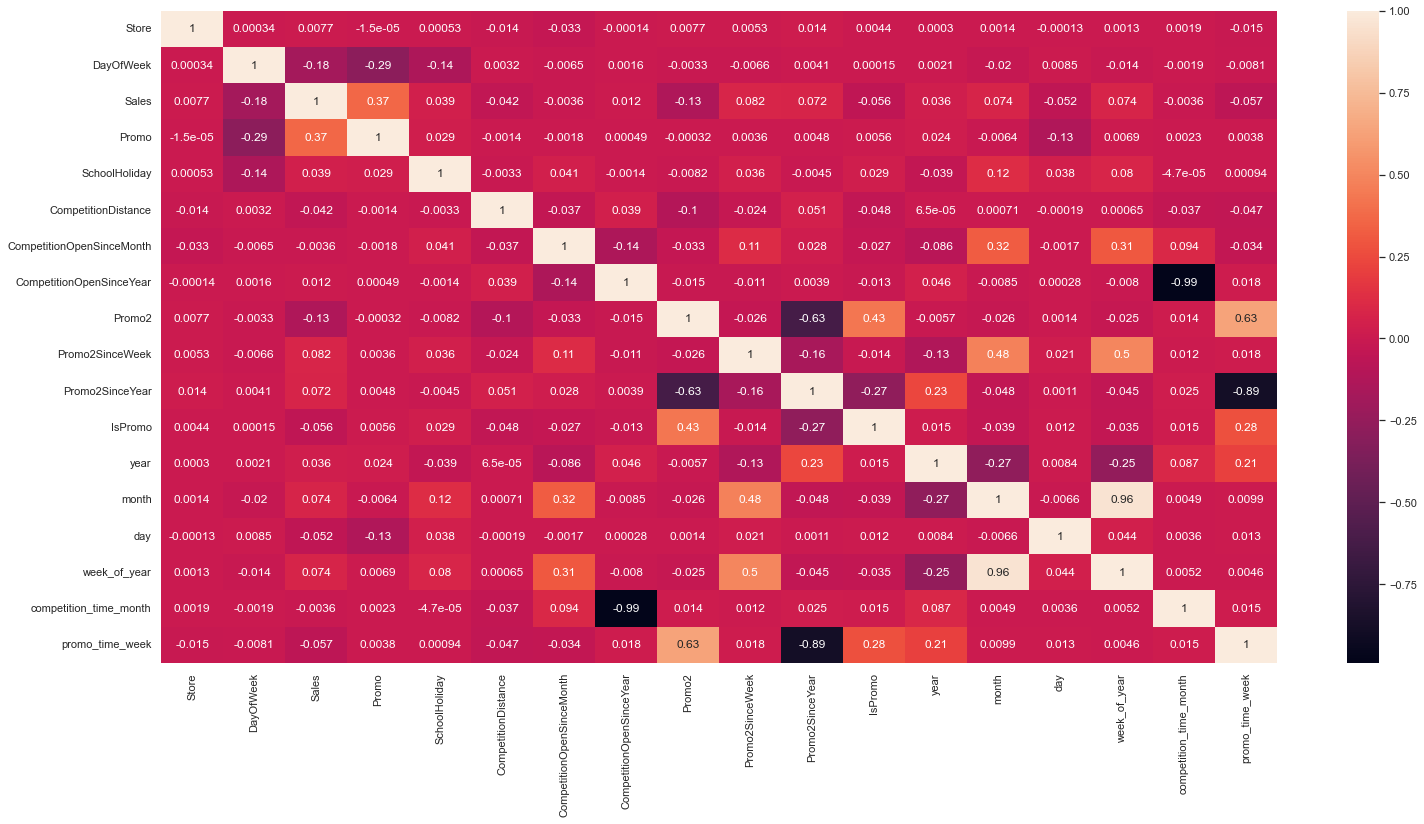

In [111]:
correlation = num_attributes_eda.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical attributes

<AxesSubplot:>

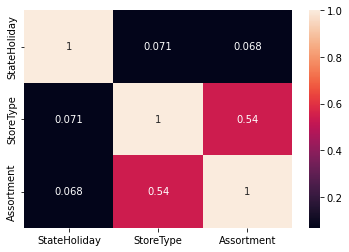

In [47]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v( a['StateHoliday'], a['StateHoliday'] )
a2 = cramer_v( a['StateHoliday'], a['StoreType'] )
a3 = cramer_v( a['StateHoliday'], a['Assortment'] )
a4 = cramer_v( a['StoreType'], a['StateHoliday'] )
a5 = cramer_v( a['StoreType'], a['StoreType'] )
a6 = cramer_v( a['StoreType'], a['Assortment'] )
a7 = cramer_v( a['Assortment'], a['StateHoliday'] )
a8 = cramer_v( a['Assortment'], a['StoreType'] )
a9 = cramer_v( a['Assortment'], a['Assortment'] )

# Final dataset
d = pd.DataFrame({'StateHoliday': [a1, a2, a3],'StoreType': [a4, a5, a6],'Assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [31]:
df5 = df4.copy()

## 5.1 Rescaling

In [32]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['CompetitionDistance'] = rs.fit_transform( df5[['CompetitionDistance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))


## 5.2 Transformation

### 5.2.1 Encoding

In [33]:
 # state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['StateHoliday'], columns=['StateHoliday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['StoreType'] = le.fit_transform(df5['StoreType'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['Assortment'] = df5['Assortment'].map(assortment_dict)

### 5.2.2 Response variable transformation

In [34]:
df5['Sales'] = np.log1p(df5['Sales'])

### 5.2.3 Nature transformation

In [35]:
# day of week
df5['day_of_week_sin'] = df5['DayOfWeek'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['DayOfWeek'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


# 6.0 Feature Selection

In [36]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [37]:
cols_drop = ['week_of_year', 'day', 'month', 'DayOfWeek', 'promo_since','competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [38]:
#selecting by 6 weeks before the last date of dataset
df6[['Store', 'Date']].groupby('Store').max().reset_index()['Date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [39]:
# training dataset
X_train = df6[df6['Date'] < '2015-06-19']
y_train = X_train['Sales']

# test dataset
X_test = df6[df6['Date'] >= '2015-06-19']
y_test = X_test['Sales']
print('Training Min Date: {}'.format(X_train['Date'].min()))
print('Training Max Date: {}'.format(X_train['Date'].max()))
print('\nTest Min Date: {}'.format( X_test['Date'].min()))
print('Test Max Date: {}'.format( X_test['Date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as a feature selection

In [40]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['Date', 'Sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


### 6.2.1 Best features from Boruta

In [41]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop(['Date', 'Sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual feature selection

In [42]:
cols_selected_boruta = ['Store', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance',
                        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
                        'Promo2SinceWeek', 'Promo2SinceYear', 'competition_time_month', 
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                        'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

# columns to add
feat_to_add = ['Date', 'Sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Model

In [43]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average model

In [72]:
aux1 = x_test.copy()
aux1['Sales'] = y_test.copy()

# prediction
aux2 = aux1[['Store', 'Sales']].groupby('Store').mean().reset_index().rename(columns={'Sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='Store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression model 

In [57]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.2 Linear Regression model cross validation

In [58]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized - Lasso

In [59]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross validation

In [60]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest

In [61]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest - Cross validation

In [62]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.4 XGBoost 

In [63]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10, 
                             subsample=0.7, 
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### 7.4.1 XGBoost - Cross validation 

In [64]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


## 7.5 Comparing Models

### 7.5.1 Single Performance

In [73]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### 7.5.2 Real Performance 

In [71]:
modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


# 8.0 Fine Tuning

## 8.1 Random Search

In [73]:
param = {'n_estimators': [1000, 2000, 3000],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [74]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    
    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])
    
    final_result

{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5
{'n_estimators': 2000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5
{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5
{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5
{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 5


In [75]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1275.53 +/- 0.0,0.16 +/- 0.0,1792.75 +/- 0.0
0,XGBoost Regressor,1129.11 +/- 0.0,0.15 +/- 0.0,1589.02 +/- 0.0
0,XGBoost Regressor,992.18 +/- 0.0,0.12 +/- 0.0,1423.33 +/- 0.0
0,XGBoost Regressor,1047.04 +/- 0.0,0.13 +/- 0.0,1516.05 +/- 0.0
0,XGBoost Regressor,1014.41 +/- 0.0,0.14 +/- 0.0,1449.64 +/- 0.0


## 8.2 Final Model

In [75]:
param_tuned = {'n_estimators': 3000,
               'eta': 0.03,
               'max_depth': 5,
               'subsample': 0.7,
               'colsample_bytree': 0.7,
               'min_child_weight': 3}

In [76]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,767.867031,0.115342,1104.999627


In [77]:
xgb_result_tunned_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb_tuned, verbose=True )
xgb_result_tunned_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,934.11 +/- 129.82,0.13 +/- 0.01,1340.47 +/- 181.16


# 9.0 Business Problem Interpretation

In [79]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['Sales'] = np.expm1(df9['Sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [80]:
# sum of predictions
df91 = df9[['Store', 'predictions']].groupby('Store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['Store', 'Sales', 'predictions']].groupby('Store').apply(lambda x: mean_absolute_error(x['Sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['Store', 'Sales', 'predictions']].groupby( 'Store' ).apply(lambda x: mean_absolute_percentage_error(x['Sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='Store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='Store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['Store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [81]:
 df92.sort_values('MAPE', ascending=False).head()

,Store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107615.710938,104215.942100,111015.479775,3399.768837,0.602434
908,909,218553.062500,210585.819187,226520.305813,7967.243313,0.520197
169,170,210332.781250,208754.922376,211910.640124,1577.858874,0.388893
901,902,202310.546875,200840.207863,203780.885887,1470.339012,0.366374
875,876,196113.046875,192048.999575,200177.094175,4064.047300,0.328779


<AxesSubplot:xlabel='Store', ylabel='MAPE'>

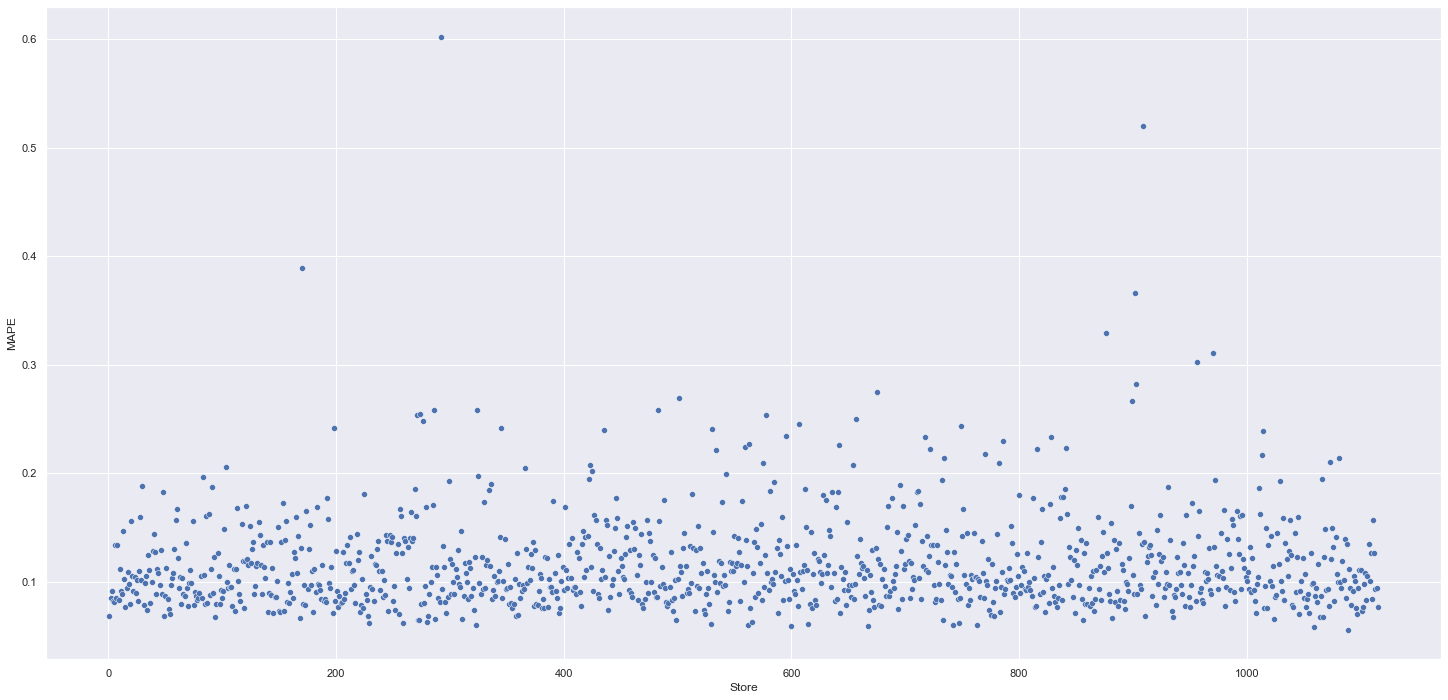

In [112]:
 sns.scatterplot(x='Store', y='MAPE', data=df92)

## 9.2 Total Performance

In [82]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,982,336.00"
1,worst_scenario,"R$285,122,909.38"
2,best_scenario,"R$286,841,799.87"


## 9.3 Machine Learning Performance

In [83]:
df9['error'] = df9['Sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['Sales']

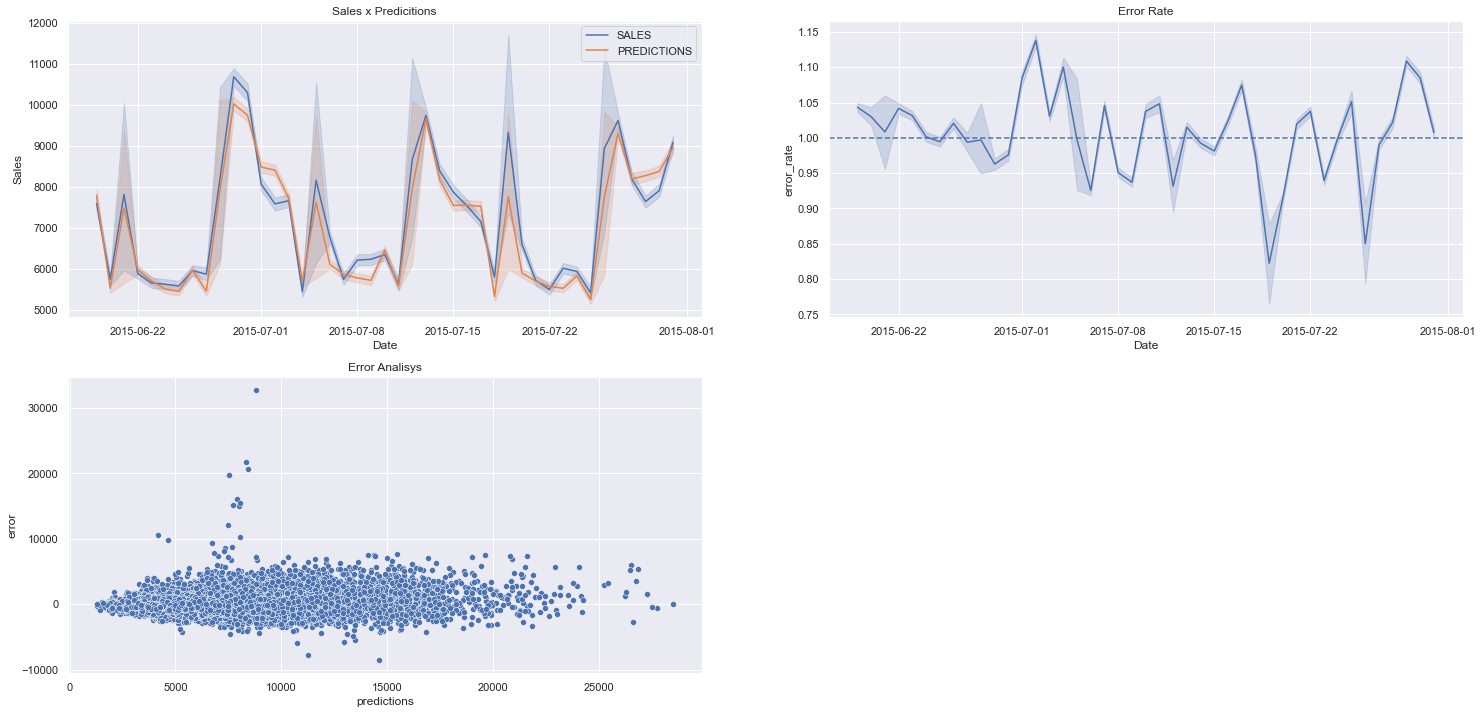

In [114]:
plt.subplot(2, 2, 1)
sns.lineplot(x='Date', y='Sales', data=df9, label='SALES')
sns.lineplot(x='Date', y='predictions', data=df9, label='PREDICTIONS')
plt.title('Sales x Predicitions');

plt.subplot(2, 2, 2)
sns.lineplot(x='Date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')
plt.title('Error Rate');

plt.subplot(2, 2, 3)
sns.scatterplot(df9['predictions'], df9['error'])
plt.title('Error Analisys');

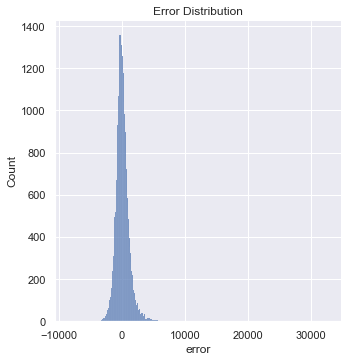

In [115]:
sns.displot(df9['error'])
plt.title('Error Distribution');

# 10.0 Model to Production

In [85]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('C:/Users/PICHAU/repos/rossman/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossman Class Creation

In [86]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:/Users/PICHAU/repos/rossman/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load( open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self, df1):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        
        # rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )
        
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )
        
        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days).astype(int)
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        # 3.0. PASSO 03 - DATA FILTRATION
        ## 3.1. Rows filtration
        df2 = df2[df2['open'] != 0]
        
        ## 3.2. Columns selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)
        
        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])
        
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))
        
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))
        
        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment','competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week','promo2_since_year', 'competition_time_month', 
                         'promo_time_week','day_of_week_sin', 'day_of_week_cos', 'month_sin', 
                         'month_cos','day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [87]:
import pickle
import requests
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('C:/Users/PICHAU/repos/rossman/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask( __name__ )
@app.route('/rossman/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        return df_response
    
    else:
        return Reponse('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run()

ModuleNotFoundError: No module named 'rossmann'

## 10.4 API Tester

In [83]:
# loading test dataset
df10 = pd.read_csv('C:/Users/PICHAU/repos/rossman/data/test.csv')

In [84]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([10, 21, 25])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [85]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [88]:
# API Call
#url = 'http://192.168.0.118:5000/rossmann/predict'
url = 'https://rossman-model-t.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data
r = requests.post(url, data=data, headers=header)
print( 'Status Code {}'.format(r.status_code))

Status Code 200


In [89]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [90]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 10 will sell R$224,906.06 in the next 6 weeks
Store Number 21 will sell R$299,213.43 in the next 6 weeks
Store Number 25 will sell R$465,248.66 in the next 6 weeks
